In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from numba import jit

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *


In [2]:
datasets = ['train', 'test', 'model']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] =  np.loadtxt('data/%s_matrix.csv.gz' % dataset).astype(int)[::9, :]

In [3]:
sample_matrices['cov'] =  np.loadtxt('../globalmaxent/data/model_matrix.csv.gz').astype(int)[::9, :]

In [4]:
observables = ['fi', 'fij', 'cij', 'fijk', 'cijk', 'fold_ijk']#, 'fijkl']
observables_dict = {key: dict() for key in observables}
for dataset in ['train', 'test', 'model']:
    params = np.load('data/%s_observables.npz'%dataset)
    for observable in observables:
        observables_dict[observable][dataset] = params[observable]

In [5]:
fi = observables_dict['fi']['train'].mean(axis=0)
sample_matrices['independent'] = np.random.choice(np.arange(0, 20, 1), size=sample_matrices['test'].shape, p=fi)

In [6]:
sample_matrices['flat'] = np.random.choice(np.arange(0, 20, 1), size=sample_matrices['test'].shape)

In [7]:
nsample = 1e7
hists_dict = {}
bins = np.arange(0, 11, 1)
for dataset in ['test', 'model', 'independent', 'flat', 'cov']:
    distances = pairwise_distances(sample_matrices[dataset], N=nsample, distance=hammingdist_jit)
    hist, _ = np.histogram(distances, bins=bins-0.5)
    hists_dict[dataset] = hist

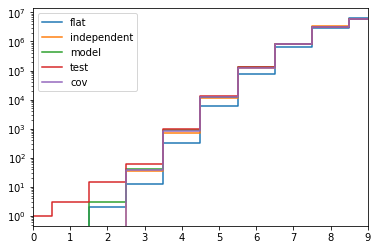

In [8]:
fig, ax = plt.subplots()
for dataset in ['flat', 'independent', 'model', 'test', 'cov']:
    ax.step(bins[:-1], hists_dict[dataset], label=dataset, where='mid')
ax.set_yscale('log')
ax.set_xticks(bins)
ax.set_xlim(bins[0], bins[-2])
ax.legend(loc='upper left');

In [51]:
kmers = np.array([list(kmer) for kmer in
                  to_kmers(pd.read_csv('../pfam/data/human_nozf.csv')['Sequence'], 9)])
filtered = map_matrix(kmers, map_)[::9]

In [52]:
distances = pairwise_distances(filtered, N=nsample, distance=hammingdist_jit)
hist, _ = np.histogram(distances, bins=bins-0.5)
hists_dict['filtered'] = hist

In [29]:
distances = pairwise_distances(sample_matrices['train'], data2=sample_matrices['test'],
                               N=nsample, distance=hammingdist_jit)
hist, _ = np.histogram(distances, bins=bins-0.5)
hists_dict['train_test'] = hist

In [30]:
arr = np.load('../aafreqpca/data/data.npz')
aa_human = arr['human']
ps = aa_human
blocklength = sample_matrices['test'].shape[0]//len(ps)
sampless = []
for p in ps:
    samples = np.random.choice(np.arange(0, 20, 1),
                               size=(blocklength, sample_matrices['test'].shape[1]),
                               p=p)
    sampless.append(samples)
sample_composition = np.concatenate(sampless)

In [31]:
distances = pairwise_distances(sample_composition, N=nsample, distance=hammingdist_jit)
hist, _ = np.histogram(distances, bins=bins-0.5)
hists_dict['composition'] = hist

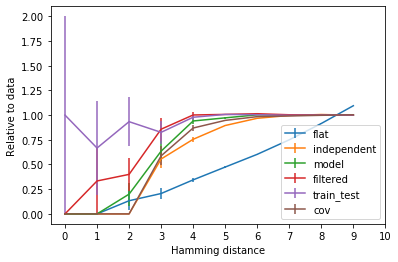

In [53]:
fig, ax = plt.subplots()
for dataset in ['flat', 'independent', 'model', 'filtered', 'train_test', 'cov']:
    ax.errorbar(bins[:-1], hists_dict[dataset]/hists_dict['test'],
                hists_dict[dataset]**.5/hists_dict['test'],
                label=dataset)
ax.set_xticks(bins)
ax.legend(loc='lower right')
ax.set_xlabel('Hamming distance')
ax.set_ylabel('Relative to data');

In [45]:
pairwise_hist = {}
for dataset in ['model', 'independent', 'flat', 'cov']:
    distances = pairwise_distances(sample_matrices[dataset],
                                   data2=sample_matrices['test'],
                                   N=nsample, distance=hammingdist_jit)
    hist, _ = np.histogram(distances, bins=bins-0.5)
    pairwise_hist[dataset] = hist

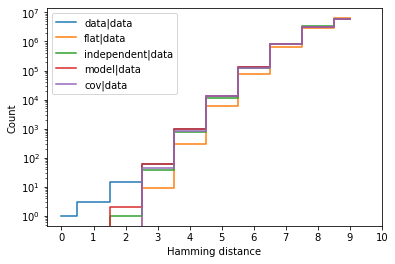

In [46]:
fig, ax = plt.subplots()
ax.step(bins[:-1], hists_dict['test'], where='mid', label='data|data')
for dataset in ['flat', 'independent', 'model', 'cov']:
    ax.step(bins[:-1], pairwise_hist[dataset], where='mid', label=dataset + '|data')
ax.set_yscale('log')
ax.set_xticks(bins);
ax.legend(loc='upper left')
ax.set_xlabel('Hamming distance')
ax.set_ylabel('Count');

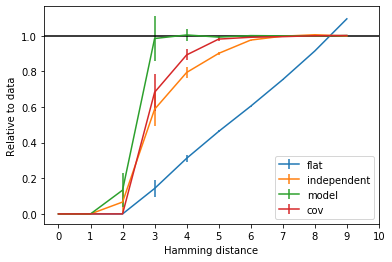

In [47]:
fig, ax = plt.subplots()
for dataset in ['flat', 'independent', 'model', 'cov']:
    ax.errorbar(bins[:-1], pairwise_hist[dataset]/hists_dict['test'],
                pairwise_hist[dataset]**.5/hists_dict['test'],
                label=dataset)
ax.set_xticks(bins)
ax.legend(loc='lower right')
ax.axhline(1.0, c='k')
ax.set_xlabel('Hamming distance')
ax.set_ylabel('Relative to data');